In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import MultipleLocator
from tslearn.piecewise import SymbolicAggregateApproximation
from hmmlearn.hmm import CategoricalHMM
import random
from sklearn.model_selection import KFold
from sklearn import preprocessing
import scipy.stats as stats
from scipy.stats import f_oneway
import ptitprince as pt
import matplotlib.collections as clt

In [2]:
class participant:
    def __init__(self,PID):
        self.PID=PID
        self.D1_rating=[]
        self.D2_rating=[]
    def __str__(self):
        print("participant: "+self.PID)
        print("Day 1: "+str(len(self.D1_rating)))
        print("Day 2: "+str(len(self.D2_rating)))
        return ""
    def update_rating(self,D1,D2):
        for rating in D1:
            self.D1_rating.extend(rating)
        for rating in D2:
            self.D2_rating.extend(rating)

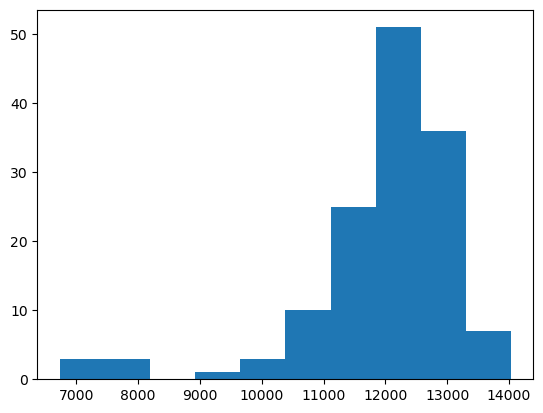

In [3]:
sharon_df=pd.read_pickle("../data/dataset/D1D2_downsampledata.pkl")
participant_list=[]
for index,row in sharon_df.iterrows():
    if row['D1_rating']!=[]:
        part=participant(row['PID'])
        part.update_rating(row['D1_rating'],row['D2_rating'])
        participant_list.append(part)
length_list=[]
for part in participant_list:
    if part.D1_rating!=[]:
        length_list.append(len(part.D1_rating))
    if part.D2_rating!=[]:
        length_list.append(len(part.D2_rating))
plt.hist(length_list)
plt.show()

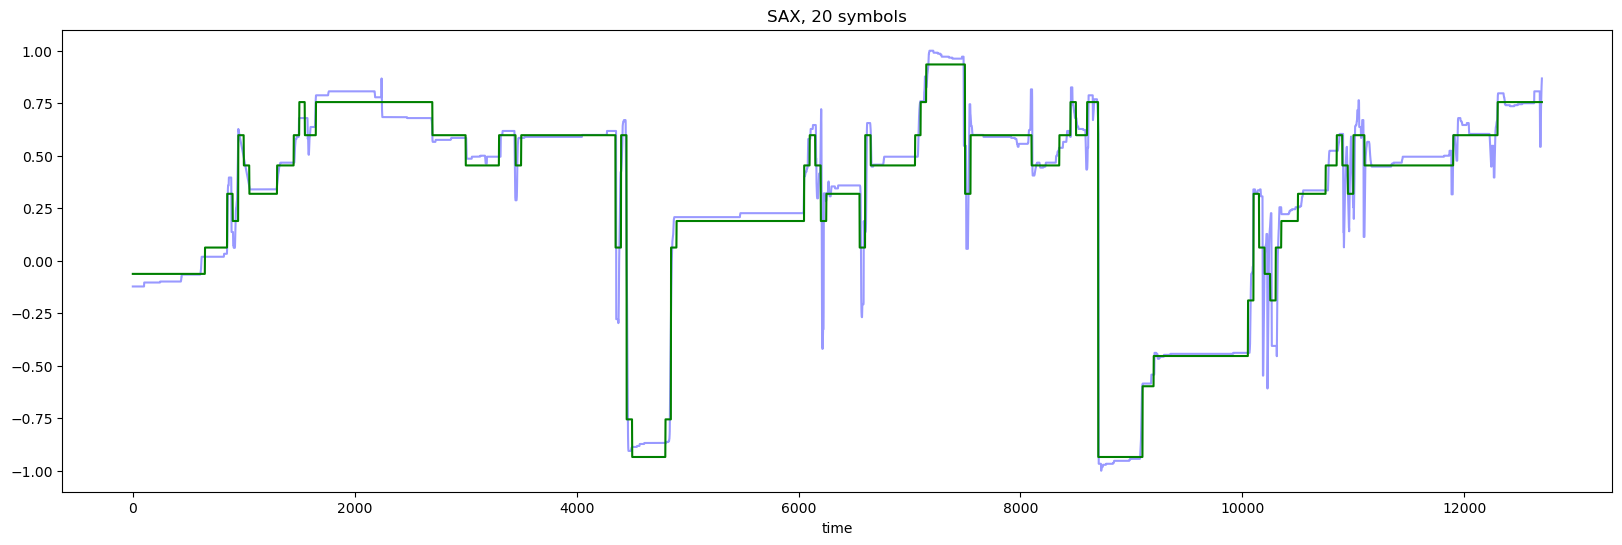

In [84]:
def add_dim(data):
    rating=np.array(data)
    rating_new=np.expand_dims(rating, 0)
    rating_new=np.expand_dims(rating_new, 2)
    return rating_new
def SAX_rating(rating,flat_length,n_sax_symbols, plot=False):
    # print(len(rating))
    if type(rating)!=np.ndarray:
        rating=np.array(rating)
    rating_norm = (rating-np.min(rating))/(np.max(rating)-np.min(rating))
    rating_norm=np.array(rating_norm)*2-1
    n_paa_segments=int(len(rating)/flat_length)
    n_paa_segments+=1
    add_length=flat_length-len(rating)%flat_length
    rating_norm=rating_norm.tolist()+[0]*add_length
    rating=add_dim(rating_norm)
    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                     alphabet_size_avg=n_sax_symbols)
    sax_dataset_inv = sax.inverse_transform(sax.fit_transform(rating))
    output=sax_dataset_inv[0].ravel()
    if plot==True:
        plt.figure(figsize=(20, 6))
        plt_rating=rating[0].ravel()
        plt.plot(plt_rating[:-1*add_length], "b-", alpha=0.4)
        plt.plot(output[:-1*add_length], "g-")
        plt.title("SAX, %d symbols" % n_sax_symbols)
        plt.xlabel("time")
        plt.show()
    return output[:-1*add_length]
Sax_sample=SAX_rating(participant_list[60].D1_rating,50,20,True)

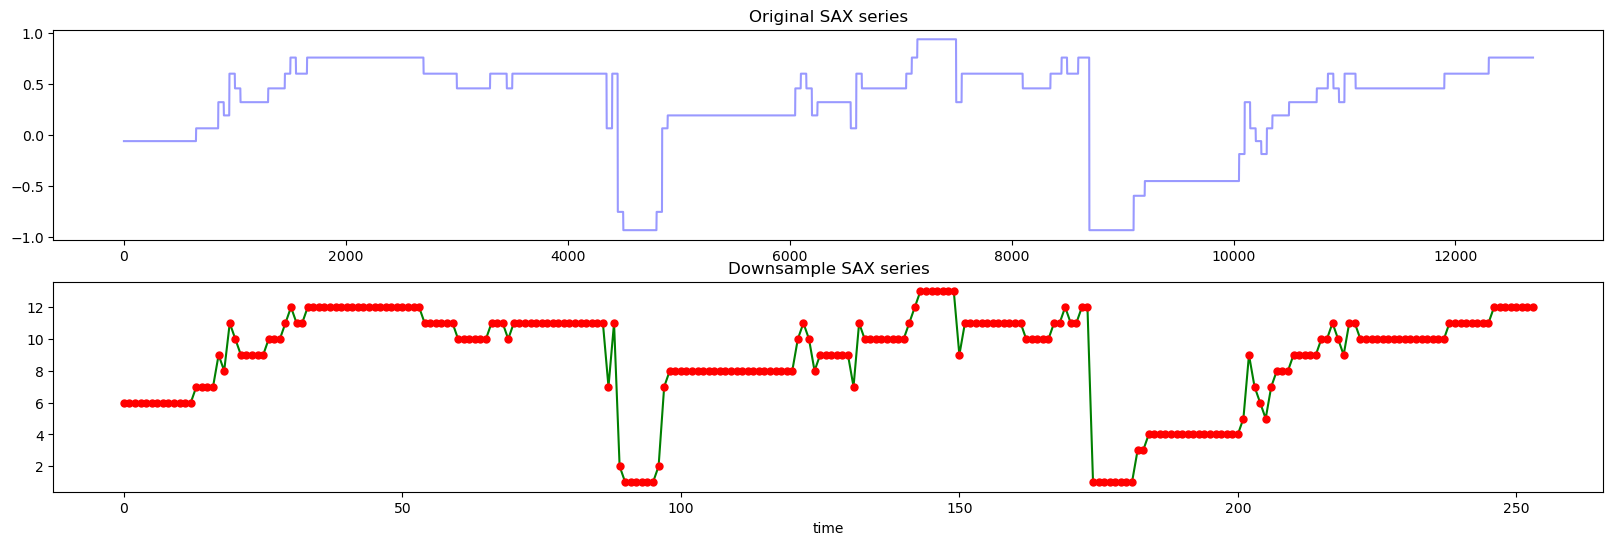

In [85]:
def downsample_SAX(SAX_rating,flat_length,multi=1,plot=False):
    downsample_SAX_list=[]
    label_set=sorted(set(SAX_rating))
    int_label_dic={}
    for label_i,label in enumerate(label_set):
        # print(label)
        int_label_dic[label]=label_i+1
    for point in SAX_rating[::flat_length]:
        for multi_i in range(multi):
            downsample_SAX_list.append(int_label_dic[point])
    if plot==True:
        # fig, ax = plt.subplots(2, 1)
        # fig.tight_layout()
        plt.figure(figsize=(20, 6))
        plt.subplot(2, 1, 1)
        plt.plot(SAX_rating.ravel(), "b-", alpha=0.4)
        plt.title("Original SAX series")
        plt.subplot(2, 1, 2)
        plt.plot(downsample_SAX_list, "g-",marker ='.',mfc='red', mec='red',ms=10)
        plt.title("Downsample SAX series")
        plt.xlabel("time")
        plt.show()
    return np.array(downsample_SAX_list)
f_length=50
downsample_SAX_sample=downsample_SAX(Sax_sample,f_length,multi=1,plot=True)

In [87]:
log_likelihood_list=[]
aic_list=[]
bic_list=[]
results={}
for nst_i in tqdm(range(5,30)):
    # print(nst_i,end=" ")
    downsample_SAX_sample=downsample_SAX(Sax_sample,f_length,multi=5,plot=False)
    observed_SAX_rating_sample = downsample_SAX_sample.reshape(-1, 1)
    # Create and train the Gaussian HMM model
    num_states = nst_i
    model_sample = CategoricalHMM(n_components=num_states)
    model_sample.fit(observed_SAX_rating_sample)
    # observed_data = Carl_rating_AllinOne.reshape(-1, 1)
    log_likelihood = model_sample.score(observed_SAX_rating_sample)
    log_likelihood_list.append(log_likelihood)

    # Calculate the Akaike Information Criterion (AIC)
    aic = model_sample.aic(observed_SAX_rating_sample)

    # Calculate the Bayesian Information Criterion (BIC)
    bic = model_sample.bic(observed_SAX_rating_sample)

    # Display the AIC and BIC
    aic_list.append(aic)
    bic_list.append(bic)
    results[nst_i]={"log_likelihood":log_likelihood,"aic":aic,"bic":bic}

  0%|          | 0/25 [00:00<?, ?it/s]

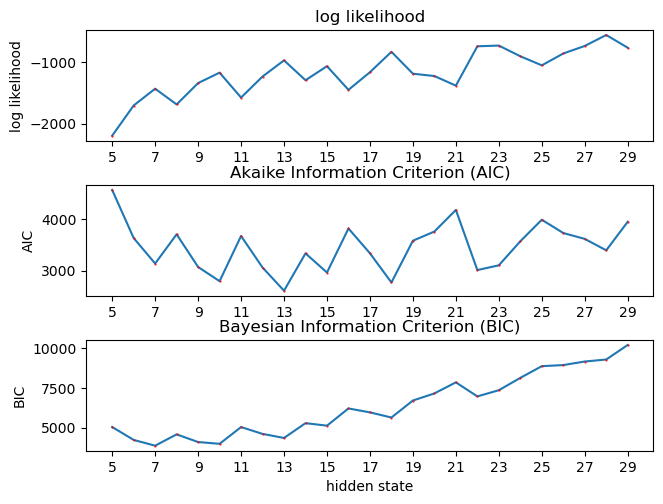

In [93]:
xlabel=range(5,30,2)
default_x_ticks = range(0,25,2)
fig, ax = plt.subplots(3, 1)
fig.tight_layout()
plt.subplot(3, 1, 1)
plt.plot(log_likelihood_list,marker ='.',mfc='red', mec='red',ms=1)
plt.xticks(default_x_ticks,xlabel)
plt.title("log likelihood")
# plt.xlabel("downsample")
plt.ylabel("log likelihood")
plt.subplot(3, 1, 2)
plt.plot(aic_list,marker ='.',mfc='red', mec='red',ms=1)
plt.xticks(default_x_ticks,xlabel)
plt.title("Akaike Information Criterion (AIC)")
# plt.xlabel("downsample")
plt.ylabel("AIC")
plt.subplot(3, 1, 3)
plt.plot(bic_list,marker ='.',mfc='red', mec='red',ms=1)
plt.xticks(default_x_ticks,xlabel)
plt.title("Bayesian Information Criterion (BIC)")
plt.xlabel("hidden state")
plt.ylabel("BIC")
plt.show()

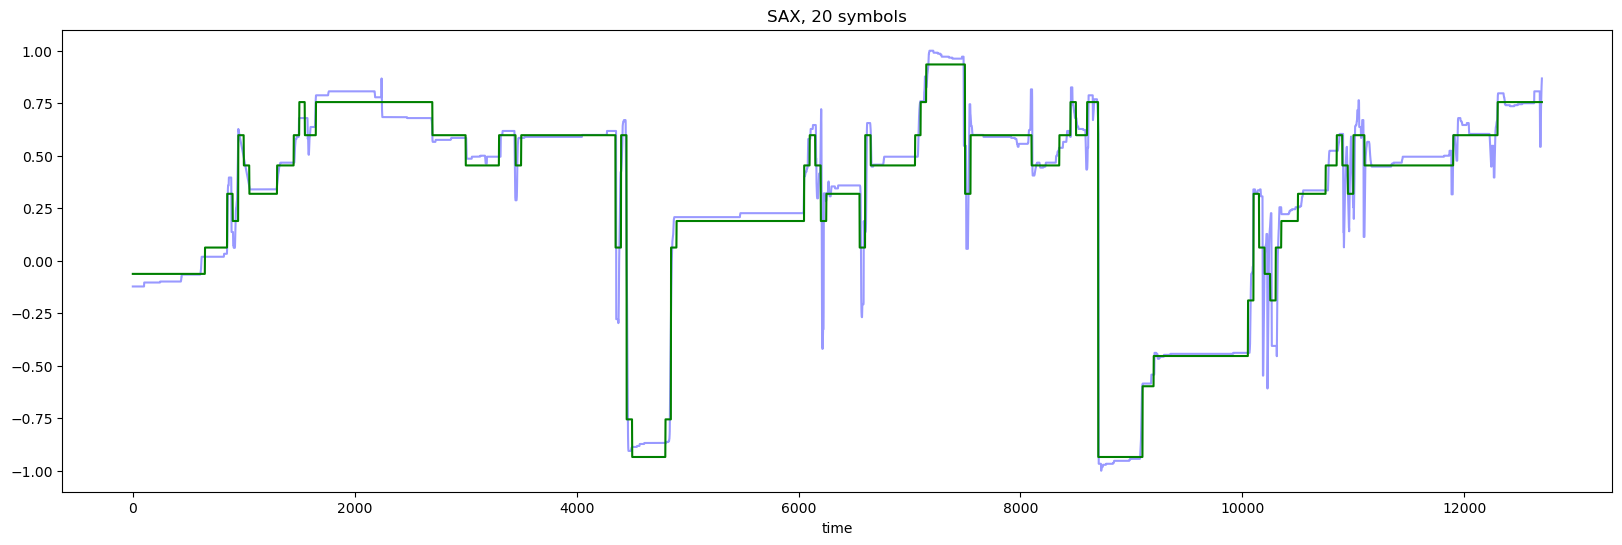

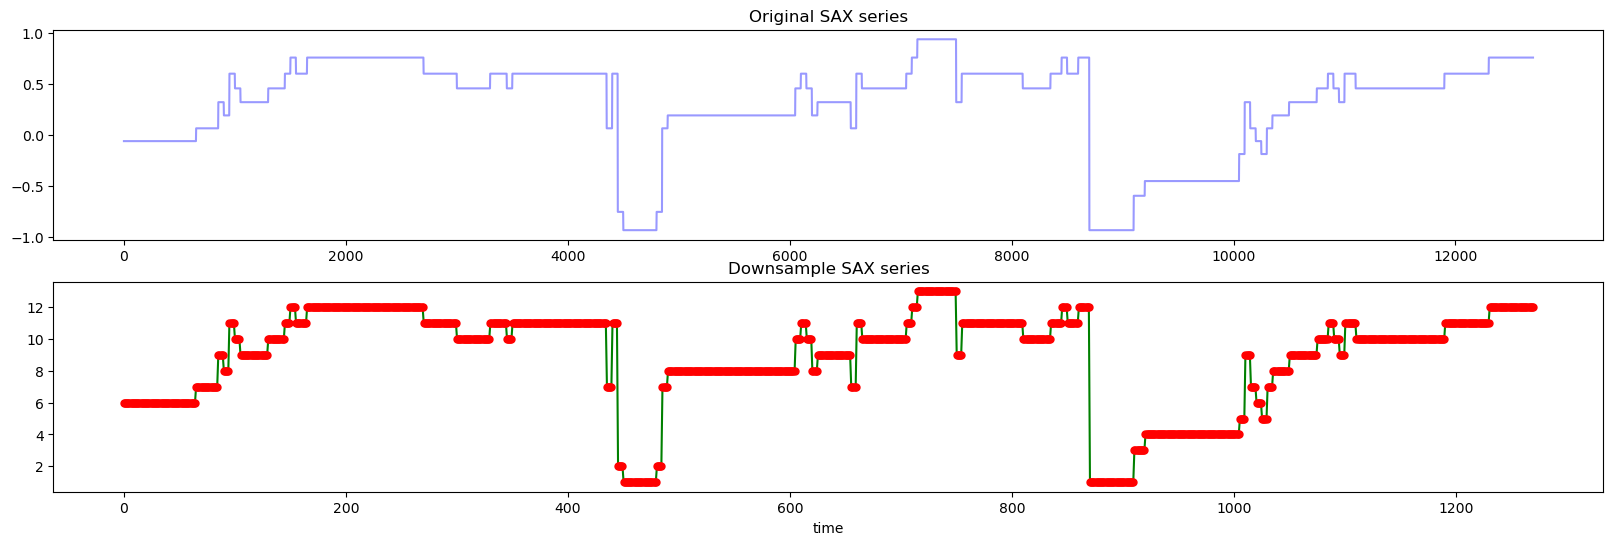

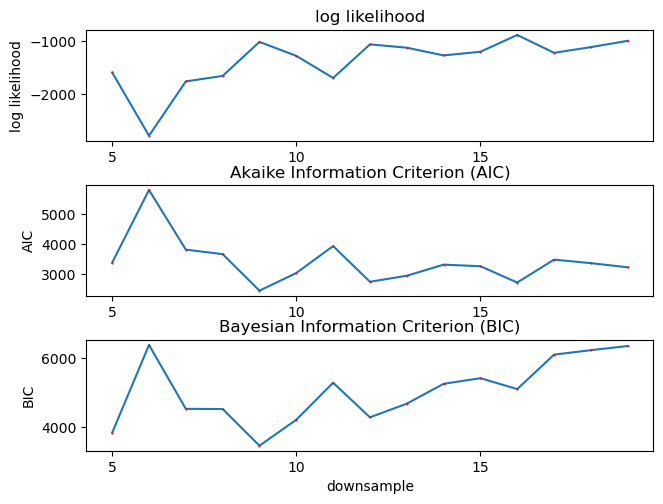

best number of state: 9


In [96]:
def normalize(result_list,minus=False):
    result_list_np=np.array(result_list)
    if minus==True:
        result_list_np=result_list_np*-1
    normalized_arr = preprocessing.normalize([result_list_np])
    return normalized_arr[0]
def select_nstate(downsample_SAX_sample,nstate_start,nstate_end,plot=False):
    log_likelihood_list=[]
    aic_list=[]
    bic_list=[]
    model_list={}
    # downsample_SAX_sample=downsample_SAX(SAX_rating,flat_length,multi=multi_num,plot=False)
    observed_SAX_rating_sample = downsample_SAX_sample.reshape(-1, 1)
    for nst_i in range(nstate_start,nstate_end):
        # Create and train the Gaussian HMM model
        num_states = nst_i
        model_sample = CategoricalHMM(n_components=num_states)
        model_sample.fit(observed_SAX_rating_sample)
        model_list[nst_i]=model_sample
        # observed_data = Carl_rating_AllinOne.reshape(-1, 1)
        log_likelihood = model_sample.score(observed_SAX_rating_sample)
        log_likelihood_list.append(log_likelihood)
        # Calculate the Akaike Information Criterion (AIC)
        aic = model_sample.aic(observed_SAX_rating_sample)
        # Calculate the Bayesian Information Criterion (BIC)
        bic = model_sample.bic(observed_SAX_rating_sample)
        # Display the AIC and BIC
        aic_list.append(aic)
        bic_list.append(bic)
    if plot==True:
        xlabel=range(nstate_start,nstate_end,5)
        default_x_ticks = range(0,nstate_end-nstate_start,5)
        fig, ax = plt.subplots(3, 1)
        fig.tight_layout()
        plt.subplot(3, 1, 1)
        plt.plot(log_likelihood_list,marker ='.',mfc='red', mec='red',ms=1)
        plt.xticks(default_x_ticks,xlabel)
        plt.title("log likelihood")
        plt.ylabel("log likelihood")
        plt.subplot(3, 1, 2)
        plt.plot(aic_list,marker ='.',mfc='red', mec='red',ms=1)
        plt.xticks(default_x_ticks,xlabel)
        plt.title("Akaike Information Criterion (AIC)")
        plt.ylabel("AIC")
        plt.subplot(3, 1, 3)
        plt.plot(bic_list,marker ='.',mfc='red', mec='red',ms=1)
        plt.xticks(default_x_ticks,xlabel)
        plt.title("Bayesian Information Criterion (BIC)")
        plt.xlabel("downsample")
        plt.ylabel("BIC")
        plt.show()
    ### Score Strategy No.1
    # log_norm=normalize(log_likelihood_list)
    # aic_norm=normalize(aic_list,True)
    # bic_norm=normalize(bic_list,True)
    # total_score=log_norm*2+aic_norm+bic_norm
    ### Score Strategy No.2
    aic_norm=normalize(aic_list)
    bic_norm=normalize(bic_list)
    total_score=aic_norm+bic_norm
    score_dic={}
    for score_i in range(nstate_start,nstate_end):
        score_dic[score_i]={"log":log_likelihood_list[score_i-nstate_start],"aic":aic_list[score_i-nstate_start],"bic":bic_list[score_i-nstate_start],"score":total_score[score_i-nstate_start]}
    max_index=min(score_dic, key=lambda v: score_dic[v]["score"])
    best_score=score_dic[max_index]
    return max_index,best_score["log"],best_score["aic"],best_score["bic"],best_score["score"],model_list
f_length=50
Sax_sample=SAX_rating(participant_list[60].D1_rating,f_length,20,True)
downsample_SAX_sample=downsample_SAX(Sax_sample,f_length,multi=5,plot=True)
best_nstate,log,aic,bic,score,model_list=select_nstate(downsample_SAX_sample,5,20,True)
print("best number of state: "+str(best_nstate))

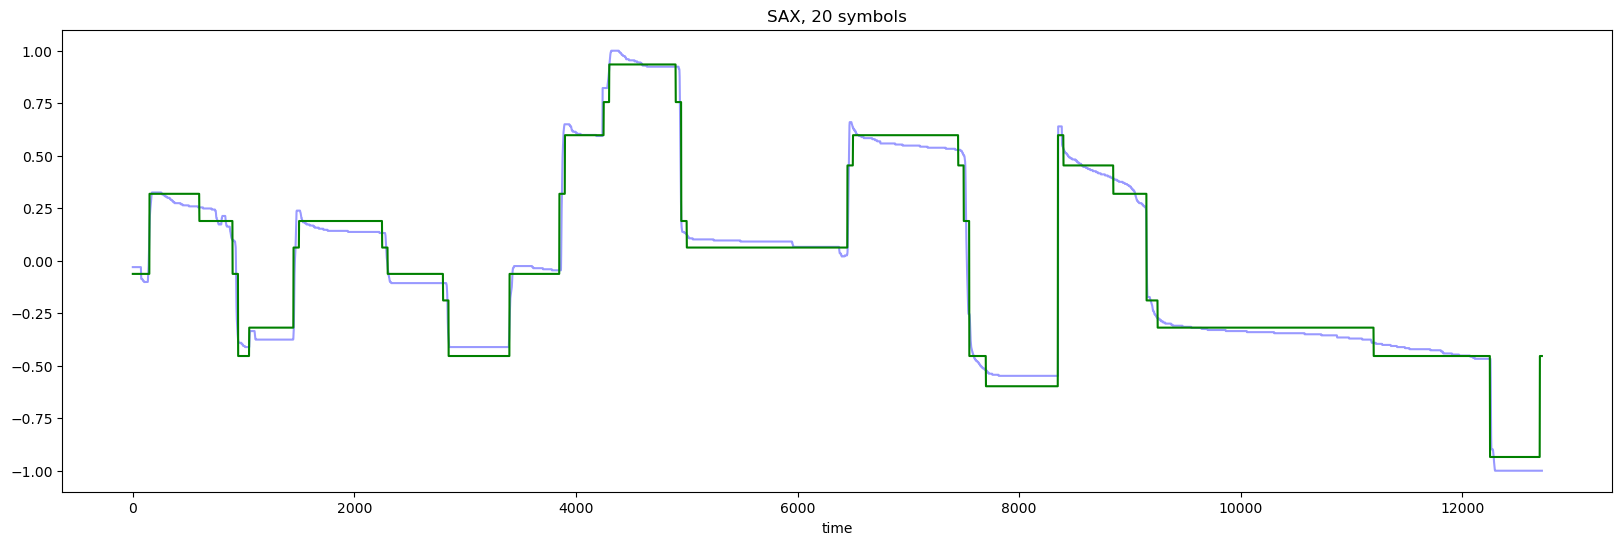

  0%|          | 0/10 [00:00<?, ?it/s]

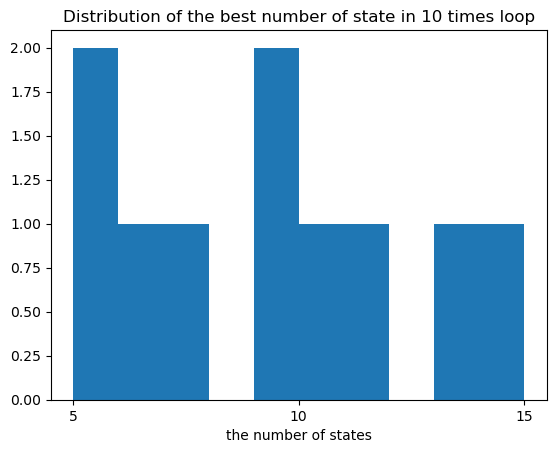

best number of state: 9


In [98]:
def find_bestnstate_modelscore(rating,flat_length,n_sax,nstate_start,nstate_end,multi_num,nloop,plot_rating=False,plot=False):
    Sax_rating=SAX_rating(rating,flat_length,n_sax, plot=plot_rating)
    downsample_SAX_sample=downsample_SAX(Sax_rating,f_length,multi=multi_num,plot=False)
    n_state_list=[]
    log_list=[]
    aic_list=[]
    bic_list=[]
    score_list=[]
    model_list_loop=[]
    for i in tqdm(range(nloop)):
        best_nstate,log,aic,bic,score,model_list=select_nstate(downsample_SAX_sample,nstate_start,nstate_end,plot=False)
        n_state_list.append(best_nstate)
        log_list.append(log)
        aic_list.append(aic)
        bic_list.append(bic)
        score_list.append(score)
        model_list_loop.append(model_list)
    if plot==True:
        plt.hist(n_state_list, bins=10)
        plt.xticks(np.arange(nstate_start,nstate_end,5))
        plt.title("Distribution of the best number of state in "+str(nloop)+" times loop")
        plt.xlabel("the number of states")
        plt.show()
    return int(np.mean(n_state_list)),np.mean(log_list),np.mean(aic_list),np.mean(bic_list),np.mean(score_list),model_list_loop
n_state,log,aic,bic,score,model_L_L=find_bestnstate_modelscore(participant_list[0].D1_rating,50,20,5,20,5,10,True,True)
print("best number of state: "+str(n_state))

In [105]:
nstate_D1=[]
nstate_D2=[]
score_D1=[]
score_D2=[]
log_D1=[]
log_D2=[]
aic_D1=[]
aic_D2=[]
bic_D1=[]
bic_D2=[]
PID_list=[]
# model_LL_list=[]
flat_length=50
n_sax=20
nstate_start=5
nstate_end=20
multi_num=5
nloop=10
for part in tqdm(participant_list):
    PID_list.append(part.PID)
    n_state,log,aic,bic,score,model_L_L=find_bestnstate_modelscore(part.D1_rating,flat_length,n_sax,\
                                                                   nstate_start,nstate_end,multi_num,\
                                                                    nloop,False,False)
    nstate_D1.append(n_state)
    score_D1.append(score)
    log_D1.append(log)
    aic_D1.append(aic)
    bic_D1.append(bic)
    # model_LL_list.append(model_L_L)
    if part.D2_rating!=[]:
        n_state,log,aic,bic,score,model_L_L=find_bestnstate_modelscore(part.D2_rating,flat_length,n_sax,\
                                                                       nstate_start,nstate_end,multi_num,\
                                                                        nloop,False,False)
        nstate_D2.append(n_state)
        score_D2.append(score)
        log_D2.append(log)
        aic_D2.append(aic)
        bic_D2.append(bic)
    else:
        nstate_D2.append(np.nan)
        score_D2.append(np.nan)
        log_D2.append(np.nan)
        aic_D2.append(np.nan)
        bic_D2.append(np.nan)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [106]:
result=pd.DataFrame({
    "PID":PID_list,
    "nstate_D1":nstate_D1,
    "score_D1":score_D1,
    "log_D1":log_D1,
    "aic_D1":aic_D1,
    "bic_D1":bic_D1,
    "nstate_D2":nstate_D2,
    "score_D2":score_D2,
    "log_D2":log_D2,
    "aic_D2":aic_D2,
    "bic_D2":bic_D2
})
result.to_pickle("../data/part_score_sharon/result.pkl")

In [109]:
nstate_D1_np=np.array(nstate_D1)
score_D1_np=np.array(score_D1)
log_D1_np=np.array(log_D1)
aic_D1_np=np.array(aic_D1)
bic_D1_np=np.array(bic_D1)
nstate_D2_np=np.array(nstate_D2)
score_D2_np=np.array(score_D2)
log_D2_np=np.array(log_D2)
aic_D2_np=np.array(aic_D2)
bic_D2_np=np.array(bic_D2)

In [111]:
print("Day 1")
print("n_state:"+str(round(np.mean(nstate_D1),2)),end="\t")
print("score:"+str(round(np.mean(score_D1),4)),end="\t")
print("log:"+str(round(np.mean(log_D1),4)),end="\t")
print("aic:"+str(round(np.mean(aic_D1),4)),end="\t")
print("bic:"+str(round(np.mean(bic_D1),4)))

print("Day 2")
nstate_D2_np_nonan = nstate_D2_np[np.logical_not(np.isnan(nstate_D2_np))]
score_D2_np_nonan = score_D2_np[np.logical_not(np.isnan(score_D2_np))]
log_D2_np_nonan = log_D2_np[np.logical_not(np.isnan(log_D2_np))]
aic_D2_np_nonan = aic_D2_np[np.logical_not(np.isnan(aic_D2_np))]
bic_D2_np_nonan = bic_D2_np[np.logical_not(np.isnan(bic_D2_np))]
print("n_state:"+str(round(np.mean(nstate_D2_np_nonan),2)),end="\t")
print("score:"+str(round(np.mean(score_D2_np_nonan),4)),end="\t")
print("log:"+str(round(np.mean(log_D2_np_nonan),4)),end="\t")
print("aic:"+str(round(np.mean(aic_D2_np_nonan),4)),end="\t")
print("bic:"+str(round(np.mean(bic_D2_np_nonan),4)))

Day 1
n_state:7.99	score:0.3575	log:-800.5768	aic:1945.3364	bic:2823.8643
Day 2
n_state:7.66	score:0.332	log:-646.4886	aic:1603.0702	bic:2390.1166


In [112]:
# D1 vs D2
t_result=stats.ttest_ind(a=nstate_D1_np, b=nstate_D2_np_nonan)
print("D1 vs D2 (n_state):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=score_D1_np, b=score_D2_np_nonan)
print("D1 vs D2 (score):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=log_D1_np, b=log_D2_np_nonan)
print("D1 vs D2 (log):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=aic_D1_np, b=aic_D2_np_nonan)
print("D1 vs D2 (aic):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=bic_D1_np, b=bic_D2_np_nonan)
print("D1 vs D2 (bic):"+str(t_result.pvalue))

D1 vs D2 (n_state):0.1981322785449934
D1 vs D2 (score):0.03228302091898195
D1 vs D2 (log):0.035595602689910626
D1 vs D2 (aic):0.03315204254037398
D1 vs D2 (bic):0.03104905371990532


In [115]:
def effect_size(group1,group2):
    mean_diff = np.mean(group2) - np.mean(group1)  # Difference in means
    pooled_std = np.sqrt(((np.std(group1) ** 2) + (np.std(group2) ** 2)) / 2)  # Pooled standard deviation
    cohen_d = mean_diff / pooled_std
    return cohen_d

In [224]:
cohen_d=effect_size(nstate_D1_np,nstate_D2_np_nonan)
print("D1 vs D2 (n_state):"+str(cohen_d))
cohen_d=effect_size(score_D1_np,score_D2_np_nonan)
print("D1 vs D2 (score):"+str(cohen_d))
cohen_d=effect_size(log_D1_np,log_D2_np_nonan)
print("D1 vs D2 (log):"+str(cohen_d))
cohen_d=effect_size(aic_D1_np,aic_D2_np_nonan)
print("D1 vs D2 (aic):"+str(cohen_d))
cohen_d=effect_size(bic_D1_np,bic_D2_np_nonan)
print("D1 vs D2 (bic):"+str(cohen_d))

D1 vs D2 (n_state):-0.2216773427485202
D1 vs D2 (score):-0.3692033691733001
D1 vs D2 (log):0.36746525035777244
D1 vs D2 (aic):-0.3720815903641293
D1 vs D2 (bic):-0.3758086196453248


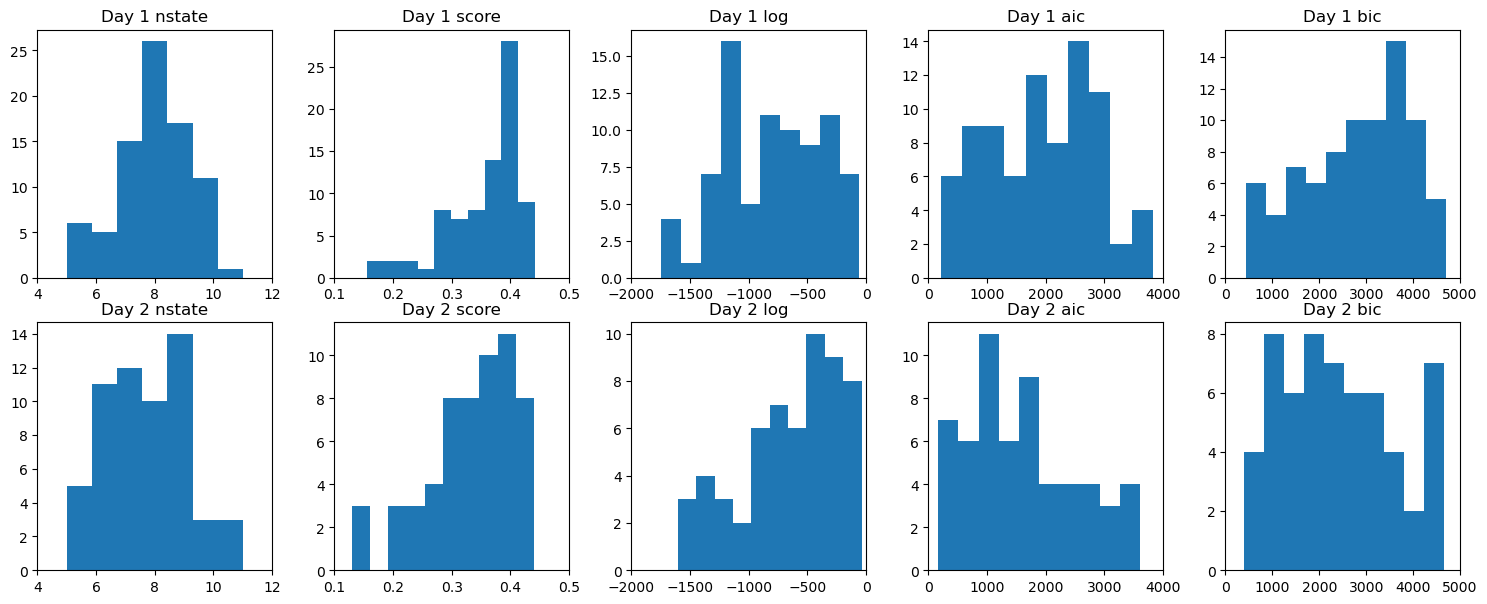

In [138]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(15,6)
fig.tight_layout()
plt.subplot(2, 5, 1)
plt.hist(nstate_D1_np,bins=7)
plt.xlim(4,12)
plt.xticks(np.arange(4,13,2))
# plt.yticks(np.arange(0,16,5))
plt.title("Day 1 nstate")
# plt.xlabel("the number of states")
plt.subplot(2, 5, 6)
plt.hist(nstate_D2_np_nonan,bins=7)
plt.xlim(4,12)
plt.xticks(np.arange(4,13,2))
# plt.yticks(np.arange(0,16,5))
plt.title("Day 2 nstate")
plt.subplot(2, 5, 2)
plt.hist(score_D1_np)
plt.xlim(0.1,0.5)
plt.xticks(np.arange(0.1,0.6,0.1))
# plt.yticks(np.arange(0,16,5))
plt.title("Day 1 score")
# plt.xlabel("the number of states")
plt.subplot(2, 5, 7)
plt.hist(score_D2_np_nonan)
plt.xlim(0.1,0.5)
plt.xticks(np.arange(0.1,0.6,0.1))
# plt.yticks(np.arange(0,16,5))
plt.title("Day 2 score")
plt.subplot(2, 5, 3)
plt.hist(log_D1_np)
plt.xlim(-2000,0)
plt.xticks(np.arange(-2000,1,500))
# plt.yticks(np.arange(0,26,5))
plt.title("Day 1 log")
# plt.xlabel("the number of states")
plt.subplot(2, 5, 8)
plt.hist(log_D2_np_nonan)
# plt.xlim(4,12)
plt.xlim(-2000,0)
plt.xticks(np.arange(-2000,1,500))
plt.title("Day 2 log")
plt.subplot(2, 5, 4)
plt.hist(aic_D1_np)
plt.xlim(0,4000)
plt.xticks(np.arange(0,4001,1000))
# plt.yticks(np.arange(0,26,5))
plt.title("Day 1 aic")
# plt.xlabel("the number of states")
plt.subplot(2, 5, 9)
plt.hist(aic_D2_np_nonan)
plt.xlim(0,4000)
plt.xticks(np.arange(0,4001,1000))
# plt.yticks(np.arange(0,26,5))
plt.title("Day 2 aic")
plt.subplot(2, 5, 5)
plt.hist(bic_D1_np)
plt.xlim(0,5000)
plt.xticks(np.arange(0,5001,1000))
# plt.yticks(np.arange(0,26,5))
plt.title("Day 1 bic")
# plt.xlabel("the number of states")
plt.subplot(2, 5, 10)
plt.hist(bic_D2_np_nonan)
plt.xlim(0,5000)
plt.xticks(np.arange(0,5001,1000))
# plt.yticks(np.arange(0,26,5))
plt.title("Day 2 bic")
plt.show()

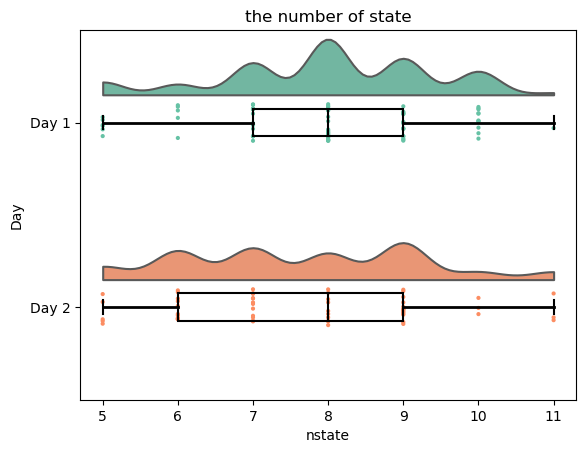

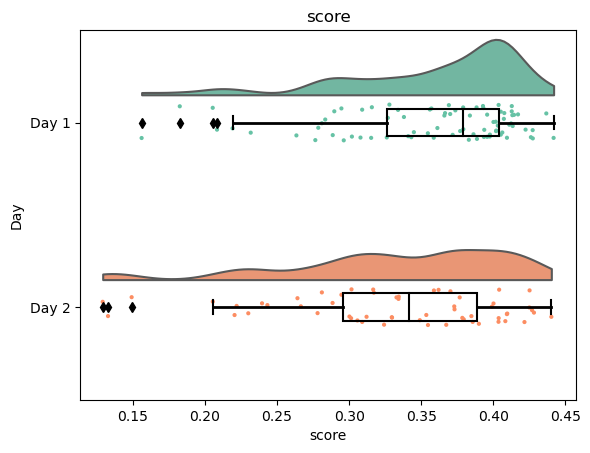

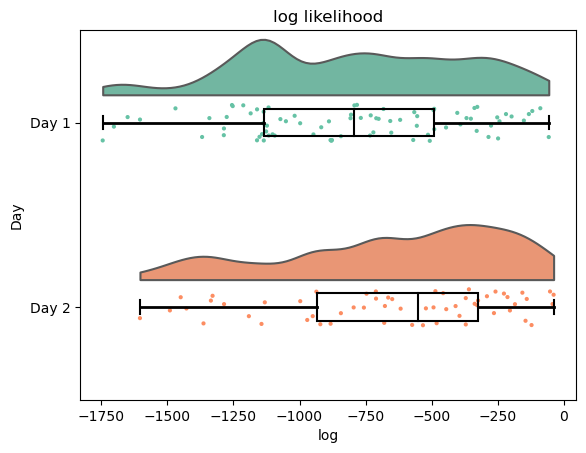

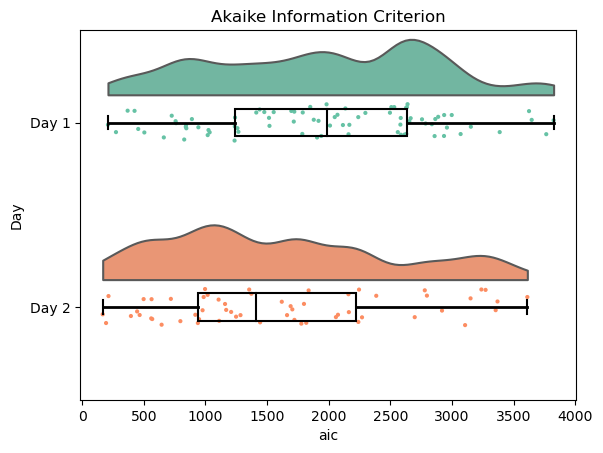

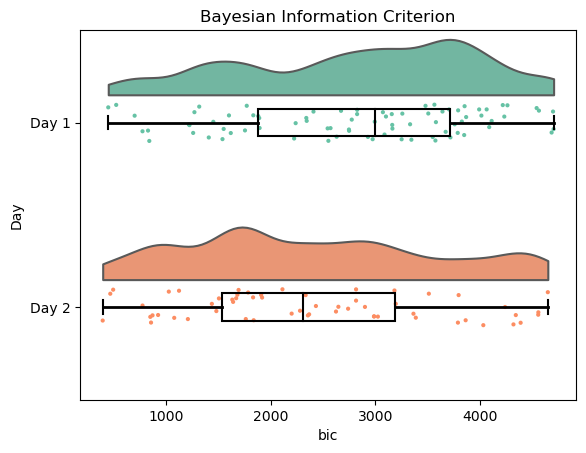

In [222]:
Day_list=["Day 1"]*len(nstate_D1_np)+["Day 2"]*len(nstate_D2_np_nonan)
nstate_list=nstate_D1+nstate_D2_np_nonan.tolist()
score_list=score_D1+score_D2_np_nonan.tolist()
log_list=log_D1+log_D2_np_nonan.tolist()
aic_list=aic_D1+aic_D2_np_nonan.tolist()
bic_list=bic_D1+bic_D2_np_nonan.tolist()
raincloud_df=pd.DataFrame({
    "Day": Day_list,
    "nstate": nstate_list,
    "score": score_list,
    "log":log_list,
    "aic":aic_list,
    "bic":bic_list
})
dy="Day"; dx="nstate"; ort="h"; pal = "Set2"
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("the number of state")
plt.show()
dy="Day"; dx="score"; ort="h"; pal = "Set2"
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("score")
plt.show()
dy="Day"; dx="log"; ort="h"; pal = "Set2"
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("log likelihood")
plt.show()
dy="Day"; dx="aic"; ort="h"; pal = "Set2"
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("Akaike Information Criterion")
plt.show()
dy="Day"; dx="bic"; ort="h"; pal = "Set2"
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("Bayesian Information Criterion")
plt.show()

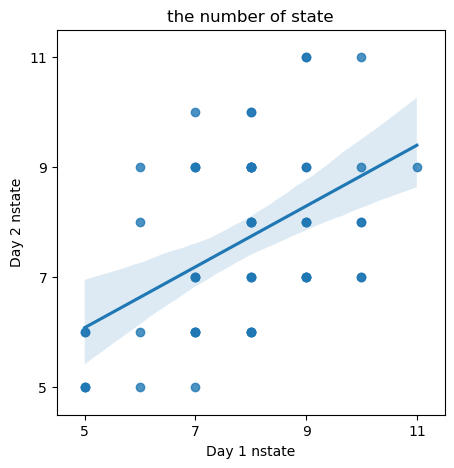

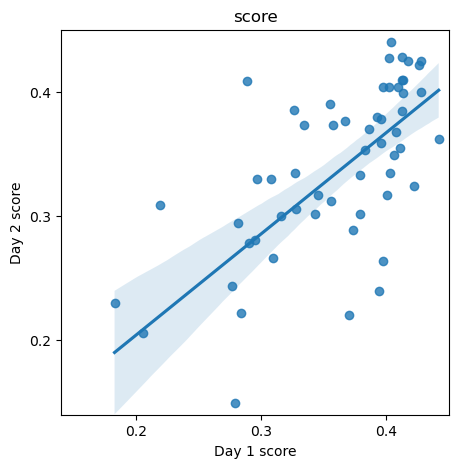

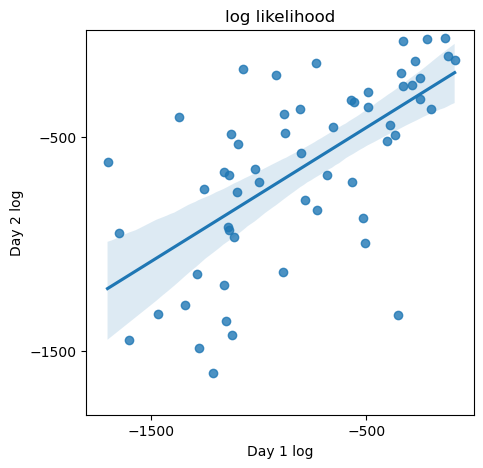

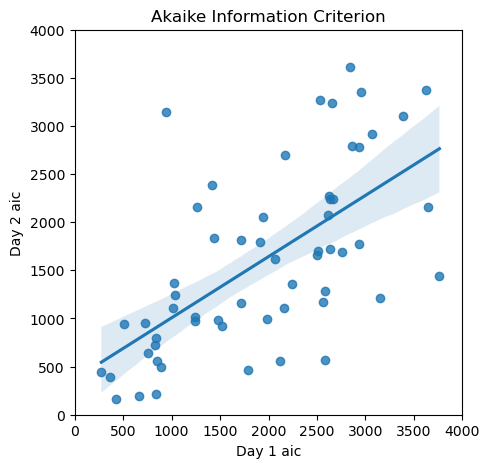

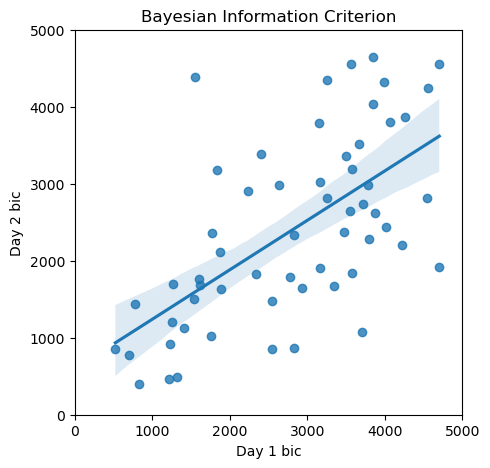

In [205]:
D1_nstate_nonan=[]
D2_nstate_nonan=[]
D1_score_nonan=[]
D2_score_nonan=[]
D1_log_nonan=[]
D2_log_nonan=[]
D1_aic_nonan=[]
D2_aic_nonan=[]
D1_bic_nonan=[]
D2_bic_nonan=[]
for part_i in range(len(participant_list)):
    if np.isnan(nstate_D2_np[part_i])==False:
        D1_nstate_nonan.append(nstate_D1_np[part_i])
        D2_nstate_nonan.append(nstate_D2_np[part_i])
        D1_score_nonan.append(score_D1_np[part_i])
        D2_score_nonan.append(score_D2_np[part_i])
        D1_log_nonan.append(log_D1_np[part_i])
        D2_log_nonan.append(log_D2_np[part_i])
        D1_aic_nonan.append(aic_D1_np[part_i])
        D2_aic_nonan.append(aic_D2_np[part_i])
        D1_bic_nonan.append(bic_D1_np[part_i])
        D2_bic_nonan.append(bic_D2_np[part_i])
D1D2_nstate=pd.DataFrame({
    'Day1_nstate':D1_nstate_nonan,
    'Day2_nstate':D2_nstate_nonan
})
D1D2_score=pd.DataFrame({
    'Day1_score':D1_score_nonan,
    'Day2_score':D2_score_nonan
})
D1D2_log=pd.DataFrame({
    'Day1_log':D1_log_nonan,
    'Day2_log':D2_log_nonan
})
D1D2_aic=pd.DataFrame({
    'Day1_aic':D1_aic_nonan,
    'Day2_aic':D2_aic_nonan
})
D1D2_bic=pd.DataFrame({
    'Day1_bic':D1_bic_nonan,
    'Day2_bic':D2_bic_nonan
})
# fig, axes = plt.subplots(2,3,figsize=(12,8.3))
# fig.suptitle("Correlation of Day 1 and Day 2 data among 58 participants")
# fig.tight_layout()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_nstate", y="Day2_nstate", data=D1D2_nstate)#,ax=axes[0,0])
plt.xlabel('Day 1 nstate')
plt.ylabel('Day 2 nstate')
plt.xlim(4.5,11.5)
plt.xticks(np.arange(5,12,2))
plt.ylim(4.5,11.5)
plt.yticks(np.arange(5,12,2))
plt.title("the number of state")
plt.show()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_score", y="Day2_score", data=D1D2_score)#,ax=axes[0,1])
plt.xlabel('Day 1 score')
plt.ylabel('Day 2 score')
plt.xlim(0.14,0.45)
plt.xticks(np.arange(0.2,0.5,0.1))
plt.ylim(0.14,0.45)
plt.yticks(np.arange(0.2,0.5,0.1))
plt.title("score")
plt.show()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_log", y="Day2_log", data=D1D2_log)#,ax=axes[0,2])
plt.xlabel('Day 1 log')
plt.ylabel('Day 2 log')
plt.xlim(-1800,0)
plt.xticks(np.arange(-1500,0,1000))
plt.ylim(-1800,0)
plt.yticks(np.arange(-1500,0,1000))
plt.title("log likelihood")
plt.show()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_aic", y="Day2_aic", data=D1D2_aic)#,ax=axes[1,0])
plt.xlabel('Day 1 aic')
plt.ylabel('Day 2 aic')
plt.xlim(0,4000)
# plt.xticks(np.arange(0,4000,1000))
plt.ylim(0,4000)
# plt.yticks(np.arange(0,4000,1000))
plt.title("Akaike Information Criterion")
plt.show()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_bic", y="Day2_bic", data=D1D2_bic)#,ax=axes[1,1])
plt.xlabel('Day 1 bic')
plt.ylabel('Day 2 bic')
plt.xlim(0,5000)
plt.ylim(0,5000)
plt.title("Bayesian Information Criterion")
plt.show()

In [207]:
P_r_nstate=stats.pearsonr(D1D2_nstate['Day1_nstate'], D1D2_nstate['Day2_nstate'])
P_r_score=stats.pearsonr(D1D2_score['Day1_score'], D1D2_score['Day2_score'])
P_r_log=stats.pearsonr(D1D2_log['Day1_log'], D1D2_log['Day2_log'])
P_r_aic=stats.pearsonr(D1D2_aic['Day1_aic'], D1D2_aic['Day2_aic'])
P_r_bic=stats.pearsonr(D1D2_bic['Day1_bic'], D1D2_bic['Day2_bic'])
print(P_r_nstate)
print(P_r_score)
print(P_r_log)
print(P_r_aic)
print(P_r_bic)

(0.4899825352751859, 9.462391630975896e-05)
(0.6778903243233407, 5.056152300209358e-09)
(0.6381117188684102, 7.118781990619057e-08)
(0.6379858776614497, 7.174282161421612e-08)
(0.6248941931109946, 1.5794174203733927e-07)
